In [ ]:
pip install xgboost

In [ ]:
pip install shap


Random Forest - Résultats:
Train RMSE: 0.8058, Test RMSE: 1.7928
Train MAE: 0.6400, Test MAE: 1.4571
Train R²: 0.9102, Test R²: 0.5545
CV RMSE: 1.7555

XGBoost - Résultats:
Train RMSE: 0.2059, Test RMSE: 1.4846
Train MAE: 0.1568, Test MAE: 1.1504
Train R²: 0.9941, Test R²: 0.6945
CV RMSE: 1.4647


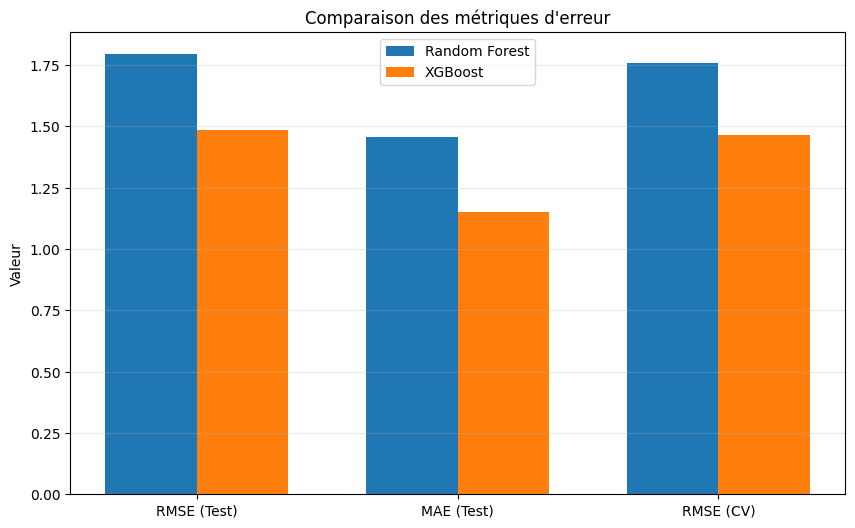

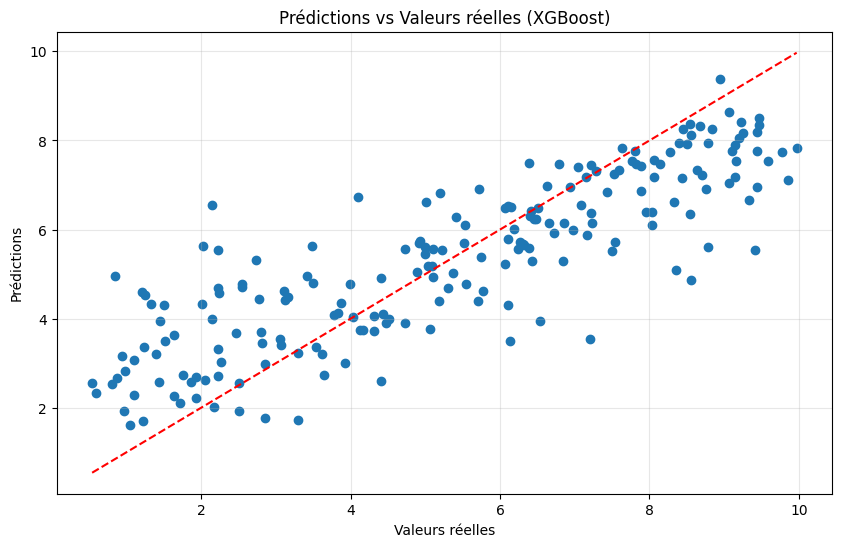

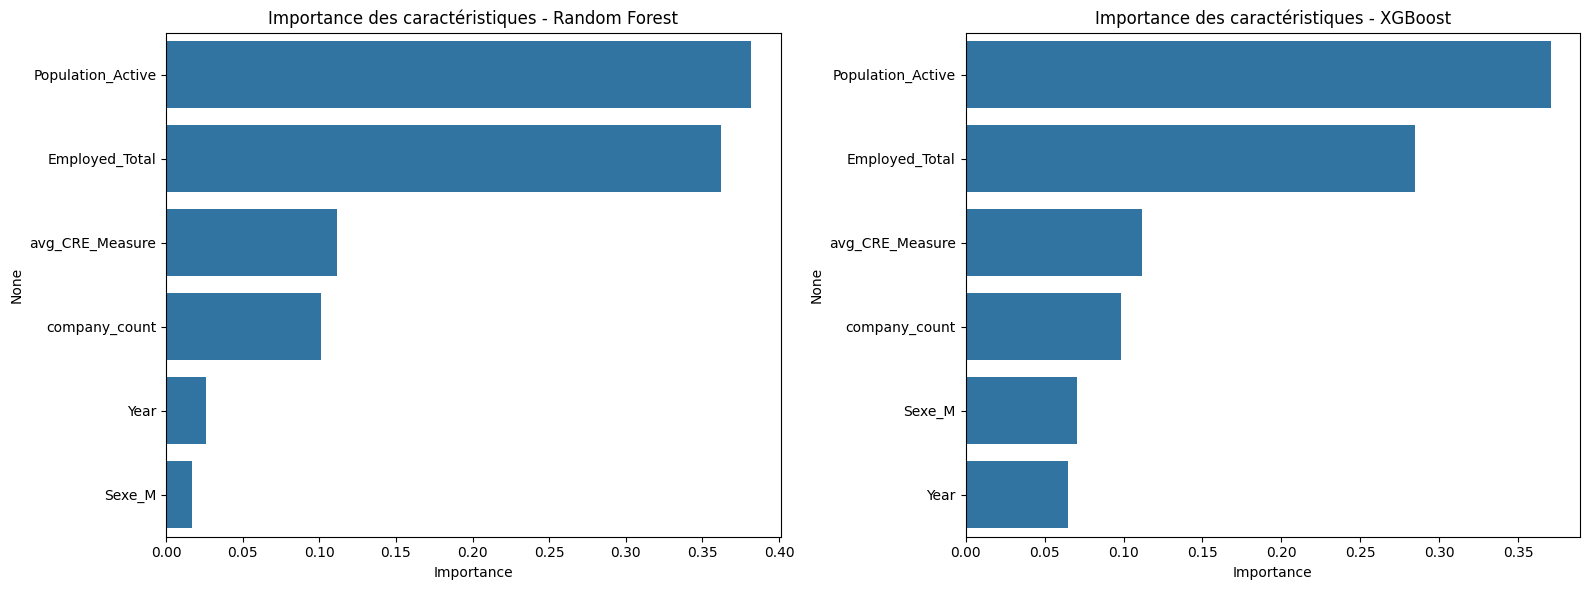


Conclusion:
XGBoost est le meilleur modèle avec un R² de 0.6945 contre 0.5545 pour Random Forest

Meilleurs hyperparamètres pour XGBoost:
learning_rate: 0.1
max_depth: 5
n_estimators: 300
subsample: 0.8


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('merged_data.csv') 

# Conversion de TIME_PERIOD en caractéristiques temporelles
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y')
df['Year'] = df['TIME_PERIOD'].dt.year
df['Month'] = df['TIME_PERIOD'].dt.month if 'Month' in str(df['TIME_PERIOD'][0]) else 1

# Encodage des variables catégorielles
encoder = OneHotEncoder(sparse_output=False, drop='first')
sexe_encoded = encoder.fit_transform(df[['Sexe']])
sexe_df = pd.DataFrame(sexe_encoded, columns=encoder.get_feature_names_out(['Sexe']))

# Fusion des données encodées
df = pd.concat([df, sexe_df], axis=1)

X = df[['Year', 'Employed_Total', 'Population_Active', 'company_count', 'avg_CRE_Measure', 'Sexe_M']]
y = df['Taux_Chomage (%)']

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ****** Modèle Random Forest*******
rf_model = RandomForestRegressor(random_state=42)

# Hyperparamètres à tester pour Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Recherche par grille pour Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

# ****** Modèle XGBoost******
xgb_model = xgb.XGBRegressor(random_state=42)

# Hyperparamètres à tester pour XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

# Recherche par grille pour XGBoost
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

# ****** Évaluation des modèles*******
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métriques d'erreur
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Affichage des résultats
    print(f"\n{model_name} - Résultats:")
    print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"CV RMSE: {cv_rmse:.4f}")
    
    return {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'cv_rmse': cv_rmse,
        'y_test': y_test,
        'y_pred': y_test_pred
    }

# Évaluation des deux modèles
rf_results = evaluate_model(rf_best, X_train, y_train, X_test, y_test, "Random Forest")
xgb_results = evaluate_model(xgb_best, X_train, y_train, X_test, y_test, "XGBoost")

# Visualisation comparative des résultats
def plot_results(rf_results, xgb_results):
    # Comparaison des métriques
    metrics = ['test_rmse', 'test_mae', 'cv_rmse']
    rf_values = [rf_results[m] for m in metrics]
    xgb_values = [xgb_results[m] for m in metrics]
    
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, rf_values, width, label='Random Forest')
    plt.bar(x + width/2, xgb_values, width, label='XGBoost')
    
    plt.xticks(x, ['RMSE (Test)', 'MAE (Test)', 'RMSE (CV)'])
    plt.ylabel('Valeur')
    plt.title('Comparaison des métriques d\'erreur')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # Prédictions vs valeurs réelles pour le meilleur modèle
    best_model = "Random Forest" if rf_results['test_r2'] > xgb_results['test_r2'] else "XGBoost"
    best_results = rf_results if best_model == "Random Forest" else xgb_results
    
    plt.figure(figsize=(10, 6))
    plt.scatter(best_results['y_test'], best_results['y_pred'])
    plt.plot([min(best_results['y_test']), max(best_results['y_test'])], 
             [min(best_results['y_test']), max(best_results['y_test'])], 'r--')
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.title(f'Prédictions vs Valeurs réelles ({best_model})')
    plt.grid(True, alpha=0.3)
    plt.show()

# Affichage graphique des résultats
plot_results(rf_results, xgb_results)

# Importance des caractéristiques
def plot_feature_importance(rf_model, xgb_model, feature_names):
    # Importance des caractéristiques pour Random Forest
    rf_importances = pd.Series(rf_model.feature_importances_, index=feature_names)
    rf_importances = rf_importances.sort_values(ascending=False)
    
    # Importance des caractéristiques pour XGBoost
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
    xgb_importances = xgb_importances.sort_values(ascending=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Random Forest
    sns.barplot(x=rf_importances.values, y=rf_importances.index, ax=ax1)
    ax1.set_title('Importance des caractéristiques - Random Forest')
    ax1.set_xlabel('Importance')
    
    # XGBoost
    sns.barplot(x=xgb_importances.values, y=xgb_importances.index, ax=ax2)
    ax2.set_title('Importance des caractéristiques - XGBoost')
    ax2.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# Affichage de l'importance des caractéristiques
plot_feature_importance(rf_best, xgb_best, X.columns)

# Conclusion
print("\nConclusion:")
if rf_results['test_r2'] > xgb_results['test_r2']:
    print(f"Random Forest est le meilleur modèle avec un R² de {rf_results['test_r2']:.4f} contre {xgb_results['test_r2']:.4f} pour XGBoost")
    best_model = rf_best
    best_model_name = "Random Forest"
else:
    print(f"XGBoost est le meilleur modèle avec un R² de {xgb_results['test_r2']:.4f} contre {rf_results['test_r2']:.4f} pour Random Forest")
    best_model = xgb_best
    best_model_name = "XGBoost"

# Affichage des meilleurs hyperparamètres
print(f"\nMeilleurs hyperparamètres pour {best_model_name}:")
if best_model_name == "Random Forest":
    params = rf_grid.best_params_
else:
    params = xgb_grid.best_params_
for param, value in params.items():
    print(f"{param}: {value}")

Entraînement du modèle XGBoost final...

Résultats du modèle XGBoost final:
Train RMSE: 0.2059, Test RMSE: 1.4846
Train MAE: 0.1568, Test MAE: 1.1504
Train R²: 0.9941, Test R²: 0.6945

Importance des caractéristiques:
             Feature  Importance
2  Population_Active    0.370483
1     Employed_Total    0.284308
4    avg_CRE_Measure    0.111500
3      company_count    0.098274
5             Sexe_M    0.070756
0               Year    0.064679


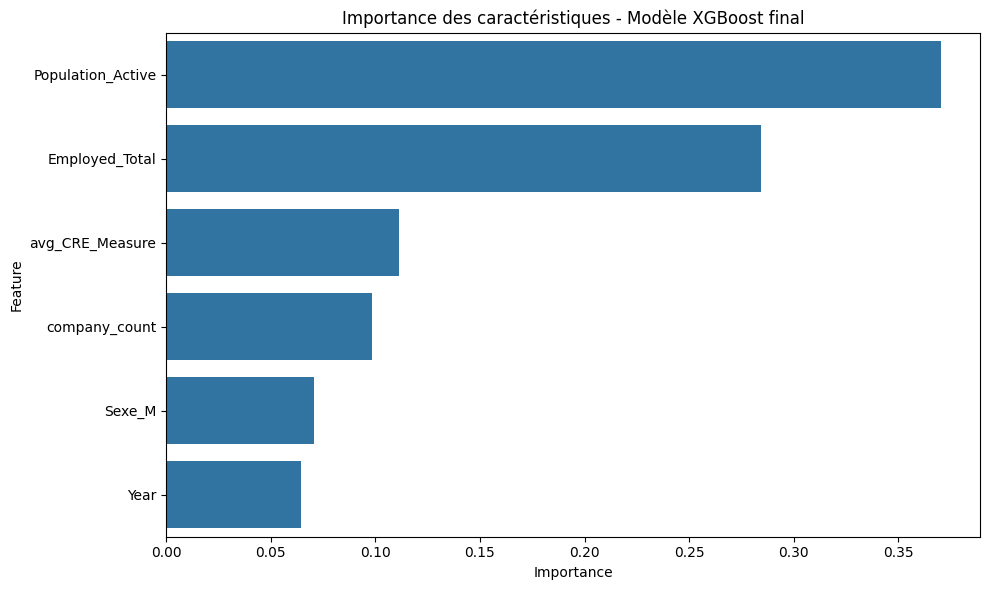

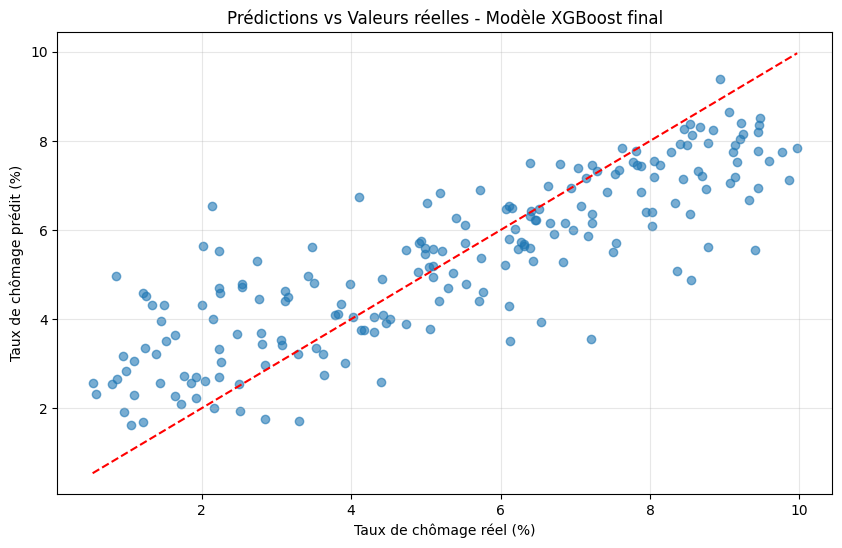


Exemple de prédiction:
Taux de chômage prédit pour 2023: 8.55%

Sauvegarde du modèle...
Modèle sauvegardé avec succès sous 'model_xgboost.pkl'
Informations sur les caractéristiques sauvegardées avec succès


In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('merged_data.csv')

df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y')
df['Year'] = df['TIME_PERIOD'].dt.year
df['Month'] = df['TIME_PERIOD'].dt.month if 'Month' in str(df['TIME_PERIOD'][0]) else 1

# Encodage des variables catégorielles
try:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
except TypeError:
    encoder = OneHotEncoder(sparse=False, drop='first')

sexe_encoded = encoder.fit_transform(df[['Sexe']])
sexe_df = pd.DataFrame(sexe_encoded, columns=encoder.get_feature_names_out(['Sexe']))

# Fusion des données encodées
df = pd.concat([df, sexe_df], axis=1)

X = df[['Year', 'Employed_Total', 'Population_Active', 'company_count', 'avg_CRE_Measure', 'Sexe_M']]
y = df['Taux_Chomage (%)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle XGBoost final avec les meilleurs hyperparamètres
print("Entraînement du modèle XGBoost final...")
final_model = xgb.XGBRegressor(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)

final_model.fit(X_train, y_train)

# Évaluation du modèle final
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Métriques de performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nRésultats du modèle XGBoost final:")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Analyse des coefficients d'importance
importance = final_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nImportance des caractéristiques:")
print(feat_importance)

# Visualisation de l'importance des caractéristiques
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title('Importance des caractéristiques - Modèle XGBoost final')
plt.tight_layout()
plt.savefig('importance_features_ancrage_territorial.png')
plt.show()

# Visualisation Prédictions vs Valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Taux de chômage réel (%)')
plt.ylabel('Taux de chômage prédit (%)')
plt.title('Prédictions vs Valeurs réelles - Modèle XGBoost final')
plt.grid(True, alpha=0.3)
plt.savefig('predictions_vs_reelles_ancrage_territorial.png')
plt.show()

# Fonction pour faire des prédictions futures
def predict_unemployment_rate(model, year, employed_total, population_active, 
                             company_count, avg_cre_measure, sexe_m):
    """
    Prédire le taux de chômage avec le modèle entraîné
    
    Parameters:
    -----------
    model : modèle XGBoost entraîné
    year : année (int)
    employed_total : nombre total d'employés (float)
    population_active : population active (float)
    company_count : nombre d'entreprises (int)
    avg_cre_measure : mesure CRE moyenne (float)
    sexe_m : 1 pour Homme, 0 pour Femme (int)
    
    Returns:
    --------
    float : Taux de chômage prédit
    """
    data = np.array([[year, employed_total, population_active, 
                    company_count, avg_cre_measure, sexe_m]])
    
    # Créer un DataFrame avec les noms de colonnes appropriés
    prediction_df = pd.DataFrame(data, columns=X.columns)
    
    # Prédire
    prediction = model.predict(prediction_df)[0]
    
    return prediction

# Exemple de prédiction
print("\nExemple de prédiction:")
prediction = predict_unemployment_rate(
    final_model, 
    2023,                    # Année
    55000,                   # Employed_Total
    60000,                   # Population_Active 
    1200,                    # company_count
    50,                      # avg_CRE_Measure
    1                        # Sexe_M (1 pour homme)
)
print(f"Taux de chômage prédit pour 2023: {prediction:.2f}%")

# Sauvegarder le modèle pour utilisation future avec Streamlit
print("\nSauvegarde du modèle...")
with open('model_xgboost.pkl', 'wb') as file:
    pickle.dump(final_model, file)

print("Modèle sauvegardé avec succès sous 'model_xgboost.pkl'")

# Sauvegarder également la structure des données d'entrée pour faciliter l'utilisation
feature_info = {
    'column_names': list(X.columns),
    'feature_importance': {name: float(importance) for name, importance in zip(X.columns, final_model.feature_importances_)}
}

with open('feature_info_ancrage_territorial.pkl', 'wb') as file:
    pickle.dump(feature_info, file)

print("Informations sur les caractéristiques sauvegardées avec succès")

Optimisation séquentielle des hyperparamètres...
Étape 1: Optimisation de max_depth et min_child_weight
Meilleurs paramètres après étape 1: max_depth=4, min_child_weight=5
Score RMSE: 0.04190243003596017

Étape 2: Optimisation de gamma
Meilleurs paramètres après étape 2: gamma=0
Score RMSE: 0.04190243003596017

Étape 3: Optimisation de subsample et colsample_bytree
Meilleurs paramètres après étape 3: subsample=0.8, colsample_bytree=0.8
Score RMSE: 0.04190243003596017

Étape 4: Optimisation de reg_alpha et reg_lambda
Meilleurs paramètres après étape 4: reg_alpha=0, reg_lambda=1
Score RMSE: 0.04190243003596017

Étape 5: Optimisation du learning_rate
Meilleurs paramètres après étape 5: learning_rate=0.05
Score RMSE final: 0.023378984028054012

Détermination du nombre optimal d'estimateurs...
  n_estimators=100, RMSE=0.028753
  n_estimators=200, RMSE=0.022689
  n_estimators=300, RMSE=0.023144
Nombre optimal d'estimateurs: 200

Entraînement du modèle final avec les meilleurs hyperparamètres

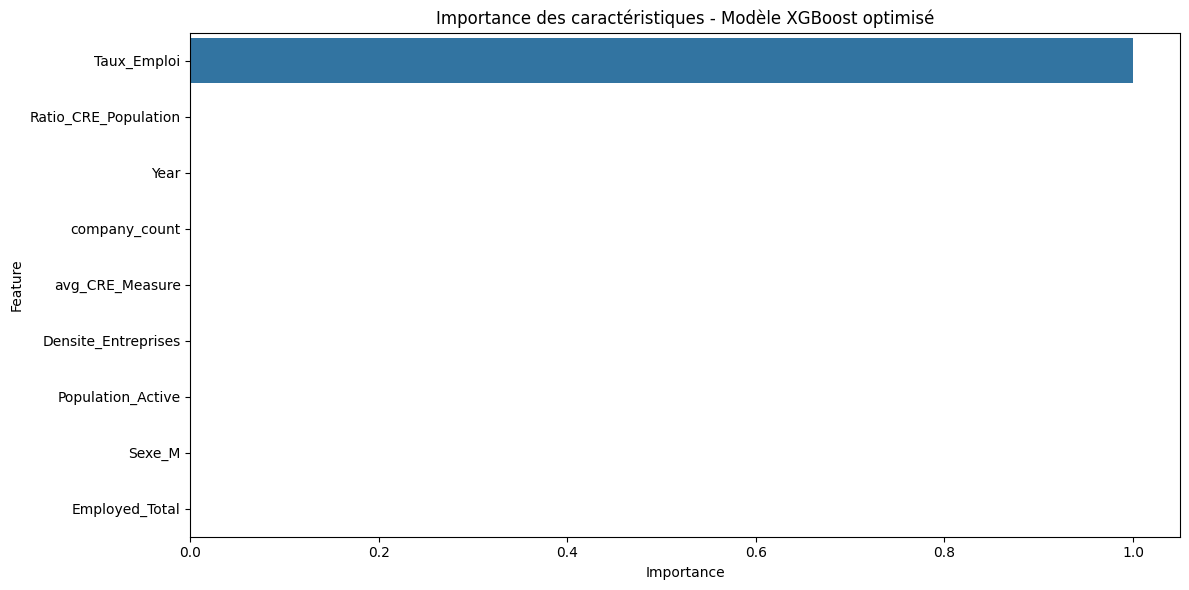

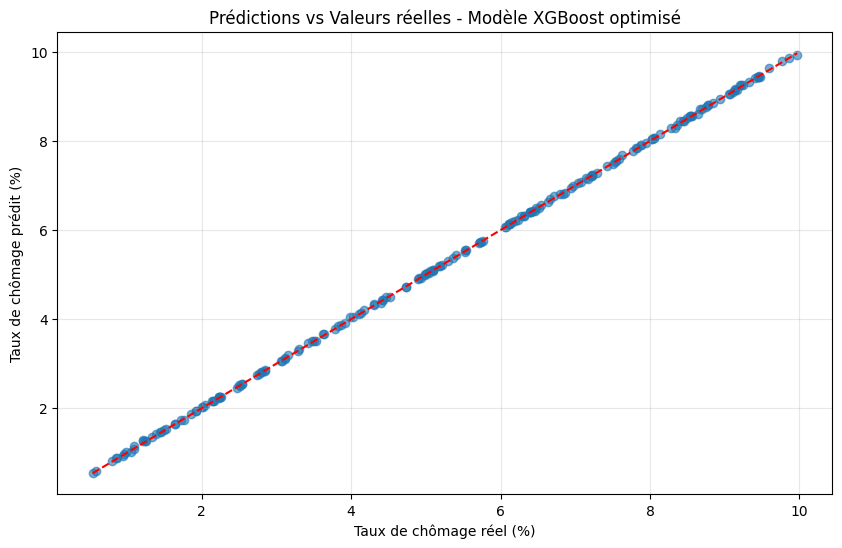

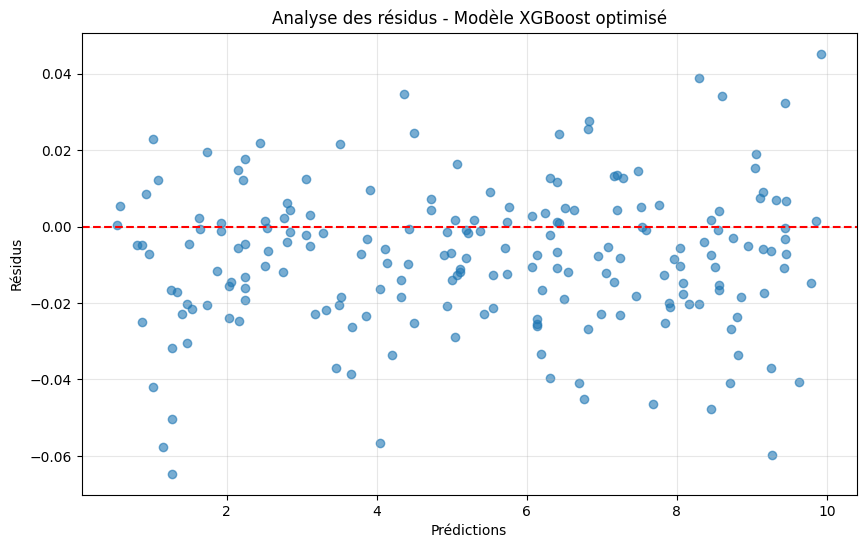


Exemple de prédiction:
Taux de chômage prédit pour 2023: 8.30%


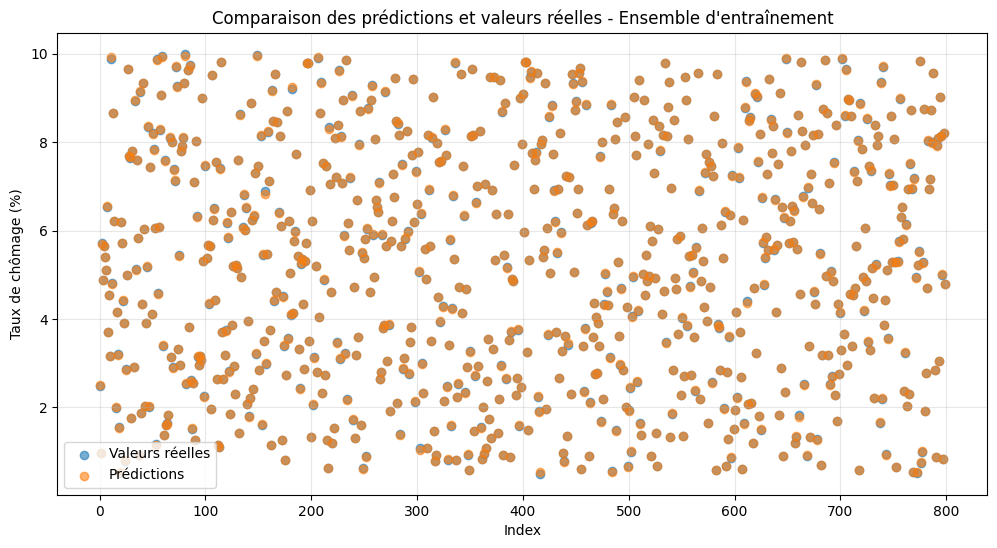

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('merged_data.csv')

# Prétraitement des données temporelles
df['TIME_PERIOD'] = pd.to_datetime(df['TIME_PERIOD'], format='%Y')
df['Year'] = df['TIME_PERIOD'].dt.year
df['Month'] = df['TIME_PERIOD'].dt.month if 'Month' in str(df['TIME_PERIOD'][0]) else 1

# Encodage des variables catégorielles
try:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
except TypeError:
    encoder = OneHotEncoder(sparse=False, drop='first')

sexe_encoded = encoder.fit_transform(df[['Sexe']])
sexe_df = pd.DataFrame(sexe_encoded, columns=encoder.get_feature_names_out(['Sexe']))

# Feature Engineering - Création de nouvelles variables
df = pd.concat([df, sexe_df], axis=1)
df['Taux_Emploi'] = df['Employed_Total'] / df['Population_Active']
df['Densite_Entreprises'] = df['company_count'] / df['Population_Active'] * 1000
df['Ratio_CRE_Population'] = df['avg_CRE_Measure'] / df['Population_Active'] * 1000

# Sélection des caractéristiques
X = df[['Year', 'Employed_Total', 'Population_Active', 'company_count', 
       'avg_CRE_Measure', 'Sexe_M', 'Taux_Emploi', 'Densite_Entreprises', 'Ratio_CRE_Population']]
y = df['Taux_Chomage (%)']

# Normalisation des variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Division en ensembles d'entraînement, validation et test
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Fonction d'optimisation des hyperparamètres par étapes
def staged_hyperparameter_tuning(X_train, X_val, y_train, y_val):
    best_params = {
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_estimators': 500,
        'eval_metric': 'rmse'  # Inclure eval_metric dans les paramètres du modèle
    }
    best_score = float('inf')
    
    print("Optimisation séquentielle des hyperparamètres...")
    
    # Étape 1: Optimisation de max_depth et min_child_weight
    print("Étape 1: Optimisation de max_depth et min_child_weight")
    param_grid1 = {
        'max_depth': [2, 3, 4],
        'min_child_weight': [3, 5, 7]
    }
    
    for max_depth in param_grid1['max_depth']:
        for min_child_weight in param_grid1['min_child_weight']:
            params = {**best_params, 'max_depth': max_depth, 'min_child_weight': min_child_weight}
            model = xgb.XGBRegressor(**params)
            
            # Version simplifiée sans early_stopping ou eval_metric dans fit()
            model.fit(X_train, y_train)
            
            val_pred = model.predict(X_val)
            score = np.sqrt(mean_squared_error(y_val, val_pred))
            
            if score < best_score:
                best_score = score
                best_params['max_depth'] = max_depth
                best_params['min_child_weight'] = min_child_weight
    
    print(f"Meilleurs paramètres après étape 1: max_depth={best_params['max_depth']}, min_child_weight={best_params['min_child_weight']}")
    print(f"Score RMSE: {best_score}")
    
    # Étape 2: Optimisation de gamma
    print("\nÉtape 2: Optimisation de gamma")
    param_grid2 = {
        'gamma': [0, 0.1, 0.2, 0.3, 0.4]
    }
    
    for gamma in param_grid2['gamma']:
        params = {**best_params, 'gamma': gamma}
        model = xgb.XGBRegressor(**params)
        
        # Version simplifiée sans early_stopping ou eval_metric dans fit()
        model.fit(X_train, y_train)
        
        val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, val_pred))
        
        if score < best_score:
            best_score = score
            best_params['gamma'] = gamma
    
    print(f"Meilleurs paramètres après étape 2: gamma={best_params.get('gamma', 0)}")
    print(f"Score RMSE: {best_score}")
    
    # Étape 3: Optimisation de subsample et colsample_bytree
    print("\nÉtape 3: Optimisation de subsample et colsample_bytree")
    param_grid3 = {
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
    }
    
    for subsample in param_grid3['subsample']:
        for colsample_bytree in param_grid3['colsample_bytree']:
            params = {**best_params, 'subsample': subsample, 'colsample_bytree': colsample_bytree}
            model = xgb.XGBRegressor(**params)
            
            # Version simplifiée sans early_stopping ou eval_metric dans fit()
            model.fit(X_train, y_train)
            
            val_pred = model.predict(X_val)
            score = np.sqrt(mean_squared_error(y_val, val_pred))
            
            if score < best_score:
                best_score = score
                best_params['subsample'] = subsample
                best_params['colsample_bytree'] = colsample_bytree
    
    print(f"Meilleurs paramètres après étape 3: subsample={best_params.get('subsample', 0.8)}, colsample_bytree={best_params.get('colsample_bytree', 0.8)}")
    print(f"Score RMSE: {best_score}")
    
    # Étape 4: Optimisation de reg_alpha et reg_lambda
    print("\nÉtape 4: Optimisation de reg_alpha et reg_lambda")
    param_grid4 = {
        'reg_alpha': [0.1, 0.5, 1, 2],
        'reg_lambda': [0.1, 0.5, 1, 2]
    }
    
    for reg_alpha in param_grid4['reg_alpha']:
        for reg_lambda in param_grid4['reg_lambda']:
            params = {**best_params, 'reg_alpha': reg_alpha, 'reg_lambda': reg_lambda}
            model = xgb.XGBRegressor(**params)
            
            # Version simplifiée sans early_stopping ou eval_metric dans fit()
            model.fit(X_train, y_train)
            
            val_pred = model.predict(X_val)
            score = np.sqrt(mean_squared_error(y_val, val_pred))
            
            if score < best_score:
                best_score = score
                best_params['reg_alpha'] = reg_alpha
                best_params['reg_lambda'] = reg_lambda
    
    print(f"Meilleurs paramètres après étape 4: reg_alpha={best_params.get('reg_alpha', 0)}, reg_lambda={best_params.get('reg_lambda', 1)}")
    print(f"Score RMSE: {best_score}")
    
    # Étape 5: Optimisation du learning_rate
    print("\nÉtape 5: Optimisation du learning_rate")
    param_grid5 = {
        'learning_rate': [0.005, 0.01, 0.05, 0.1]
    }
    
    for learning_rate in param_grid5['learning_rate']:
        params = {**best_params, 'learning_rate': learning_rate}
        model = xgb.XGBRegressor(**params)
        
        # Version simplifiée sans early_stopping ou eval_metric dans fit()
        model.fit(X_train, y_train)
        
        val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, val_pred))
        
        if score < best_score:
            best_score = score
            best_params['learning_rate'] = learning_rate
    
    print(f"Meilleurs paramètres après étape 5: learning_rate={best_params.get('learning_rate', 0.1)}")
    print(f"Score RMSE final: {best_score}")
    
    # Déterminer le meilleur nombre d'estimateurs avec validation manuelle
    print("\nDétermination du nombre optimal d'estimateurs...")
    max_estimators = 1000
    best_n_estimators = best_params.get('n_estimators', 500)
    best_score_n = float('inf')
    
    # Tester différents nombres d'estimateurs
    for n_estimators in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        params = {**best_params, 'n_estimators': n_estimators}
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        
        val_pred = model.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, val_pred))
        
        print(f"  n_estimators={n_estimators}, RMSE={score:.6f}")
        
        if score < best_score_n:
            best_score_n = score
            best_n_estimators = n_estimators
        else:
            # Si pas d'amélioration après deux essais consécutifs, on arrête
            if n_estimators >= 300:
                break
    
    best_params['n_estimators'] = best_n_estimators
    print(f"Nombre optimal d'estimateurs: {best_params['n_estimators']}")
    
    return best_params

# Exécution de l'optimisation des hyperparamètres
best_params = staged_hyperparameter_tuning(X_train, X_val, y_train, y_val)

# Entraînement du modèle final avec les meilleurs paramètres
print("\nEntraînement du modèle final avec les meilleurs hyperparamètres...")
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train_full, y_train_full)

# Évaluation sur les données de test
y_train_pred = final_model.predict(X_train_full)
y_test_pred = final_model.predict(X_test)

# Métriques de performance
train_rmse = np.sqrt(mean_squared_error(y_train_full, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train_full, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train_full, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nRésultats du modèle XGBoost final:")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

# Validation croisée pour une évaluation plus robuste
print("\nValidation croisée du modèle final:")
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(final_model, X_scaled_df, y, cv=kfold, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print(f"CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

# Analyse des coefficients d'importance
importance = final_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("\nImportance des caractéristiques:")
print(feat_importance)

# Visualisation de l'importance des caractéristiques
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title('Importance des caractéristiques - Modèle XGBoost optimisé')
plt.tight_layout()
plt.show()

# Visualisation Prédictions vs Valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Taux de chômage réel (%)')
plt.ylabel('Taux de chômage prédit (%)')
plt.title('Prédictions vs Valeurs réelles - Modèle XGBoost optimisé')
plt.grid(True, alpha=0.3)
plt.show()

# Analyse des résidus
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Analyse des résidus - Modèle XGBoost optimisé')
plt.grid(True, alpha=0.3)
plt.show()

# Fonction pour faire des prédictions futures
def predict_unemployment_rate(model, year, employed_total, population_active, 
                             company_count, avg_cre_measure, sexe_m):
    """
    Prédire le taux de chômage avec le modèle XGBoost optimisé
    
    Parameters:
    -----------
    model : modèle XGBoost entraîné
    year : année (int)
    employed_total : nombre total d'employés (float)
    population_active : population active (float)
    company_count : nombre d'entreprises (int)
    avg_cre_measure : mesure CRE moyenne (float)
    sexe_m : 1 pour Homme, 0 pour Femme (int)
    
    Returns:
    --------
    float : Taux de chômage prédit
    """
    # Calcul des caractéristiques dérivées
    taux_emploi = employed_total / population_active
    densite_entreprises = company_count / population_active * 1000
    ratio_cre_population = avg_cre_measure / population_active * 1000
    
    # Création d'un DataFrame pour respecter le format attendu
    input_data = pd.DataFrame({
        'Year': [year],
        'Employed_Total': [employed_total],
        'Population_Active': [population_active],
        'company_count': [company_count],
        'avg_CRE_Measure': [avg_cre_measure],
        'Sexe_M': [sexe_m],
        'Taux_Emploi': [taux_emploi],
        'Densite_Entreprises': [densite_entreprises],
        'Ratio_CRE_Population': [ratio_cre_population]
    })
    
    # Appliquer la normalisation
    input_scaled = scaler.transform(input_data)
    
    # Prédire
    prediction = model.predict(input_scaled)[0]
    
    return prediction

# Exemple de prédiction
print("\nExemple de prédiction:")
prediction = predict_unemployment_rate(
    final_model, 
    2023,                    # Année
    55000,                   # Employed_Total
    60000,                   # Population_Active 
    1200,                    # company_count
    50,                      # avg_CRE_Measure
    1                        # Sexe_M (1 pour homme)
)
print(f"Taux de chômage prédit pour 2023: {prediction:.2f}%")

# Sauvegarde du modèle pour utilisation future
""" print("\nSauvegarde du modèle...")
model_data = {
    'model': final_model,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'feature_importance': feat_importance.to_dict(),
    'hyperparameters': best_params
}

with open('xgboost_optimized_model.pkl', 'wb') as file:
    pickle.dump(model_data, file)

print("Modèle sauvegardé avec succès sous 'xgboost_optimized_model.pkl'") """

# Affichage de la courbe d'apprentissage - Version simplifiée
# Comme nous n'utilisons pas eval_set, nous ne pouvons pas afficher la courbe d'apprentissage standard
# À la place, nous pouvons créer une visualisation des prédictions vs les valeurs réelles
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_train_full)), y_train_full, label='Valeurs réelles', alpha=0.6)
plt.scatter(range(len(y_train_pred)), y_train_pred, label='Prédictions', alpha=0.6)
plt.title('Comparaison des prédictions et valeurs réelles - Ensemble d\'entraînement')
plt.xlabel('Index')
plt.ylabel('Taux de chômage (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()